In [71]:
# import all the necessary packages
!pip install keras
import os
import sys
import random
import warnings
from pylab import imshow, show, get_cmap

#packages for tensor and array calculations
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
 #tqdm is used for displaying a progress bar 
from tqdm import tqdm

from itertools import chain

#keras package along with tensroflow backend for deep learning
from keras.models import Model, load_model, Sequential

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras import backend as K
import tensorflow as tf


from tensorflow.keras.layers import Input, Dense, UpSampling2D, Flatten, Reshape
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate

#images display and basic operations
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
#from skimage.util import crop, pad
from skimage.morphology import label
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
import cv2
import glob



In [72]:
#dimensions of the image to be processed and compressed

IMG_WIDTH = 96
IMG_HEIGHT = 64
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [73]:
#Load X_train, X_test
cv_img_train = []
cv_img_test = []
for img in glob.glob("/kaggle/input/imagenet-mini/ImageNet-Mini/train/*.JPEG"):
    n= cv2.imread(img)
    cv_img_train.append(n)

for img in glob.glob("/kaggle/input/imagenet-mini/ImageNet-Mini/test/*.JPEG"):
    n= cv2.imread(img)
    cv_img_test.append(n)

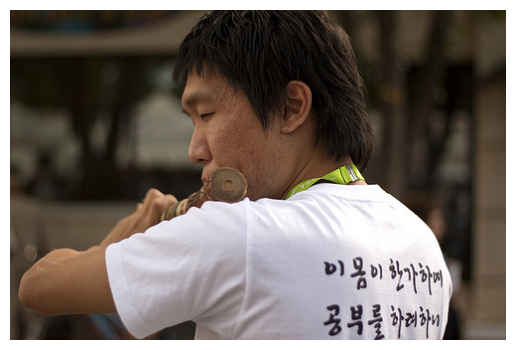

In [74]:
#Show X_train
if cv_img:
    img_rgb = cv2.cvtColor(cv_img[0], cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

In [75]:
print("Train Dataset Length:",len(cv_img_train))
print("Test Dataset Length:",len(cv_img_test))

Train Dataset Length: 1200
Test Dataset Length: 300


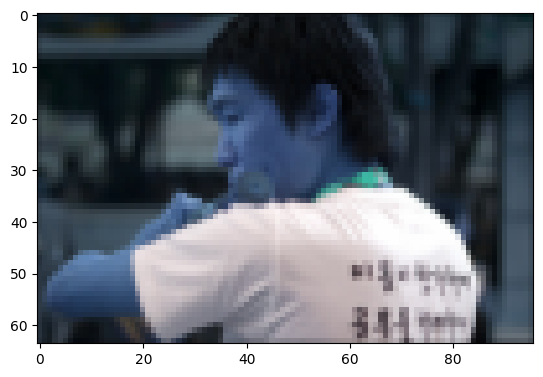

In [76]:
#Inicialize 0-padding X_train, X_test
X_train = np.zeros((len(cv_img_train), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')
X_test = np.zeros((len(cv_img_test), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')

#Store X_train, X_test
init = 0
for i in cv_img_train:
    img = i.astype('float32') / 255.
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    X_train[init] = img
    init = init + 1
init = 0
for i in cv_img_test:
    img = i.astype('float32') / 255.
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    X_test[init] = img
    init = init + 1   
    
plt.imshow(X_train[0])

In [77]:
X_train.shape

(1200, 64, 96, 3)

In [78]:
def Encoder():
    inp = Input(shape=INPUT_SHAPE)
    x = Conv2D(128, (4, 4), activation='elu', padding='same',name='encode1')(inp)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode3')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode4')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode5')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode6')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode7')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode8')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',name='encode9')(x)
    x = Flatten()(x)
    x = Dense(256, activation='elu',name='encode10')(x)
    encoded = Dense(128, activation='sigmoid',name='encode11')(x)
    return Model(inp, encoded)

encoder = Encoder()
encoder.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 64, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode1 (Conv2D)                │ (None, 64, 96, 128)    │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode2 (Conv2D)                │ (None, 64, 96, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 32, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode3 (Conv2D)                │ (None, 32, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode4 (Conv2D)                │ (None, 32, 48, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 16, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode5 (Conv2D)                │ (None, 16, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode6 (Conv2D)                │ (None, 16, 24, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 8, 12, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode7 (Conv2D)                │ (None, 8, 12, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode8 (Conv2D)                │ (None, 8, 12, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode9 (Conv2D)                │ (None, 4, 6, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode10 (Dense)                │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode11 (Dense)                │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,664 (1.59 MB)

 Trainable params: 417,664 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
D_INPUT_SHAPE=[128]
def Decoder():
    inp = Input(shape=D_INPUT_SHAPE, name='decoder')
    x = Dense(256, activation='elu', name='decode1')(inp)
    x = Dense(768, activation='elu', name='decode2')(x)
    x = Reshape((4, 6, 32))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode7')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode9')(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode10')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode11')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode12')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='decode13')(x)
    x = Conv2D(16, (2, 2), activation='elu', padding='same', name='decode14')(x)
    decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same', name='decode15')(x)
    return Model(inp, decoded)

decoder = Decoder()
decoder.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder (InputLayer)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode2 (Dense)                 │ (None, 768)            │       197,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode3 (Conv2D)                │ (None, 4, 6, 32)       │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode4 (Conv2D)                │ (None, 4, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_40 (UpSampling2D) │ (None, 8, 12, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode5 (Conv2D)                │ (None, 8, 12, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode6 (Conv2D)                │ (None, 8, 12, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_41 (UpSampling2D) │ (None, 16, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode7 (Conv2D)                │ (None, 16, 24, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode8 (Conv2D)                │ (None, 16, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_42 (UpSampling2D) │ (None, 32, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode9 (Conv2D)                │ (None, 32, 48, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode10 (Conv2D)               │ (None, 32, 48, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode11 (Conv2D)               │ (None, 32, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_43 (UpSampling2D) │ (None, 64, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode12 (Conv2D)               │ (None, 64, 96, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode13 (Conv2D)               │ (None, 64, 96, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode14 (Conv2D)               │ (None, 64, 96, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode15 (Conv2D)               │ (None, 64, 96, 1)      │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 694,065 (2.65 MB)

 Trainable params: 694,065 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
from keras.layers import LeakyReLU
def Autoencoder():
    inp = Input(shape=INPUT_SHAPE)
    x = Conv2D(128, (4, 4), activation='elu', padding='same',name='encode1')(inp)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode3')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode4')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode5')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode6')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode7')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode8')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',name='encode9')(x)
    x = Flatten()(x)
    x = Dense(256, activation='elu',name='encode10')(x)
    
    encoded = Dense(128, activation='sigmoid',name='encode11')(x)
    x = Dense(256, activation='elu', name='decode1')(encoded)
    x = Dense(768, activation='elu', name='decode2')(x)
    x = Reshape((4, 6, 32))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
    x = UpSampling2D((2, 2))(x)


#     x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
#     x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
#     x = Conv2DTranspose(64, (3,3),padding='same')(x)
#     x = LeakyReLU()(x)
#     x = UpSampling2D((2, 2))(x)
#     x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
#     x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
#     x = Conv2DTranspose(64, (3,3),padding='same')(x)
#     x = LeakyReLU()(x)
#     x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode7')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode9')(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode10')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode11')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode12')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='decode13')(x)
    x = Conv2D(16, (2, 2), activation='elu', padding='same', name='decode14')(x)
    decoded = Conv2D(3, (2, 2), activation='sigmoid', padding='same', name='decode15')(x)
    return Model(inp, decoded)

model = Autoencoder()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 64, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode1 (Conv2D)                │ (None, 64, 96, 128)    │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode2 (Conv2D)                │ (None, 64, 96, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 32, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode3 (Conv2D)                │ (None, 32, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode4 (Conv2D)                │ (None, 32, 48, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 16, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode5 (Conv2D)                │ (None, 16, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode6 (Conv2D)                │ (None, 16, 24, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 8, 12, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode7 (Conv2D)                │ (None, 8, 12, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode8 (Conv2D)                │ (None, 8, 12, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode9 (Conv2D)                │ (None, 4, 6, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode10 (Dense)                │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode2 (Dense)                 │ (None, 768)            │       197,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode3 (Conv2D)                │ (None, 4, 6, 32)       │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode4 (Conv2D)                │ (None, 4, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_44 (UpSampling2D) │ (None, 8, 12, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode5 (Conv2D)                │ (None, 8, 12, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode6 (Conv2D)                │ (None, 8, 12, 64)      │        18,49

 Total params: 1,111,859 (4.24 MB)

 Trainable params: 1,111,859 (4.24 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
filepath = "Dancer_Auto_Model.keras"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=8,
                              verbose=1,
                              mode='min',
                              restore_best_weights=True)

In [82]:
class ImgSample(Callback):

    def __init__(self):
       super(Callback, self).__init__() 

    def on_epoch_end(self, epoch, logs={}):
        sample_img = X_train[50]
        sample_img = sample_img.reshape(1, IMG_HEIGHT, IMG_WIDTH, 3)
        sample_img = self.model.predict(sample_img)[0]
        #imshow(sample_img.reshape(64,96))
        imshow(sample_img.reshape(IMG_HEIGHT, IMG_WIDTH, 3))
        plt.show()

imgsample = ImgSample()


## aux_loss
import tensorflow as tf
from tensorflow.keras import layers as L

class AuxLossCallback(tf.keras.callbacks.Callback):
    def __init__(self, encoder, decoder, X_train, X_test):
        self.encoder = encoder
        self.decoder = decoder
        self.X_train = X_train
        self.X_test = X_test

    def on_epoch_end(self, epoch, logs=None):
        train_mse_loss = self.calculate_mse_loss(self.X_train)
        val_mse_loss = self.calculate_mse_loss(self.X_test, is_train=False)
        
        train_bitrate_loss = self.calculate_bitrate_loss(self.X_train)
        val_bitrate_loss = self.calculate_bitrate_loss(self.X_test, is_train=False)
        
        train_aux_loss = (train_mse_loss + train_bitrate_loss) / 2
        val_aux_loss = (val_mse_loss + val_bitrate_loss) / 2
        
        print(f'Epoch {epoch+1}, Train aux_loss={train_aux_loss}, Val aux_loss={val_aux_loss}, '
              f'Train MSE={train_mse_loss}, Val MSE={val_mse_loss}, '
              f'Train Bitrate={train_bitrate_loss}, Val Bitrate={val_bitrate_loss}, '
              f'Loss={logs.get("loss")}')
    
    """
    def calculate_loss(self, data, is_train=True):
        if is_train:
            reconstructions = self.decoder.predict(self.encoder.predict(data))
        else:
            reconstructions = self.decoder.predict(self.encoder.predict(data))
        return tf.keras.losses.mean_squared_error(data, reconstructions).numpy()
    """
    def calculate_mse_loss(self, data, is_train=True):
        reconstructions = self.decoder.predict(self.encoder.predict(data))
        mse_loss = tf.keras.losses.mean_squared_error(data, reconstructions).numpy().mean()
        return mse_loss

    def calculate_bitrate_loss(self, data, is_train=True):

        bitrate_loss = 0.0 
        return bitrate_loss

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


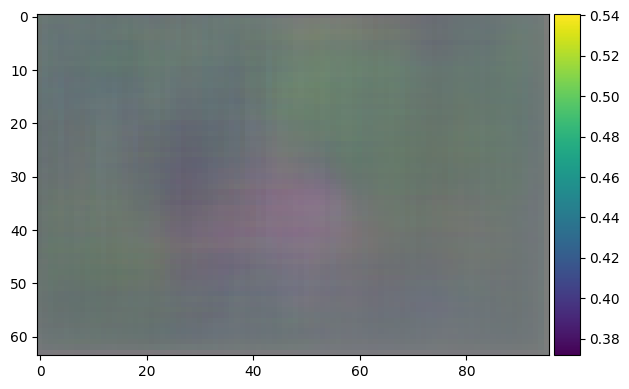

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 821ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 391ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 760ms/step
Epoch 1, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.0713638961315155
36/36 - 306s - 9s/step - loss: 0.0714 - val_loss: 0.0683 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


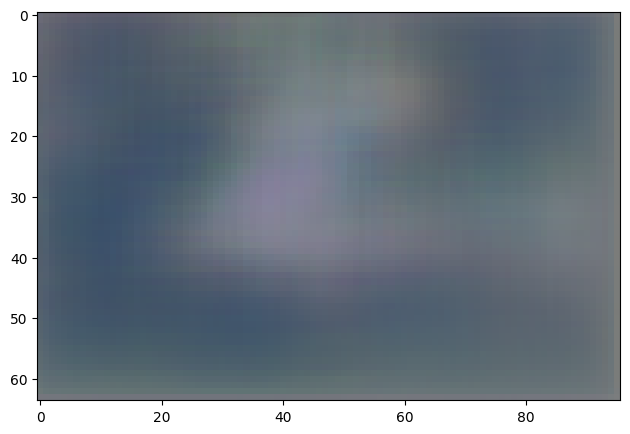

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 761ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 766ms/step
Epoch 2, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.06497514247894287
36/36 - 316s - 9s/step - loss: 0.0650 - val_loss: 0.0570 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


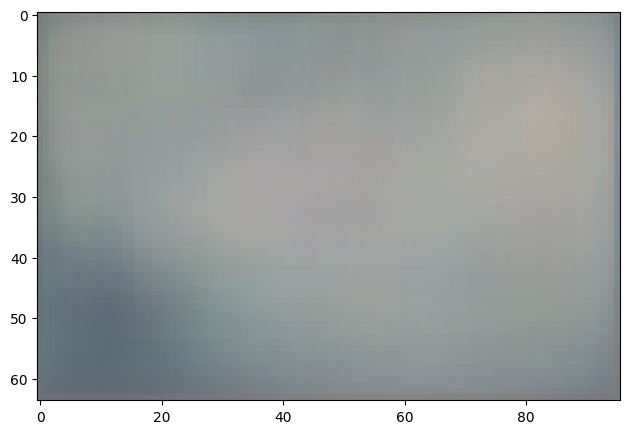

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 754ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 769ms/step
Epoch 3, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.048962369561195374
36/36 - 296s - 8s/step - loss: 0.0490 - val_loss: 0.0433 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


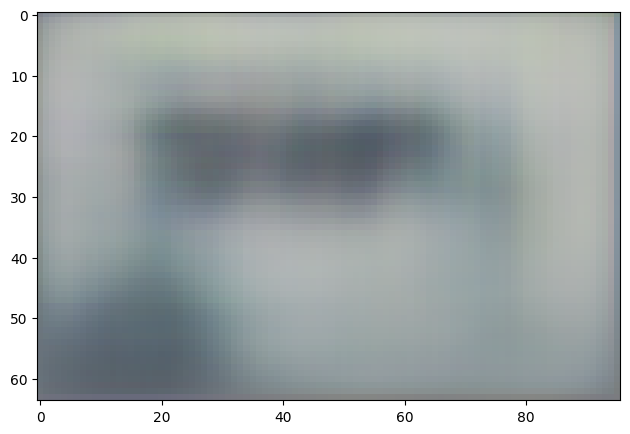

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 390ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 760ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 389ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 769ms/step
Epoch 4, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.04300783574581146
36/36 - 308s - 9s/step - loss: 0.0430 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


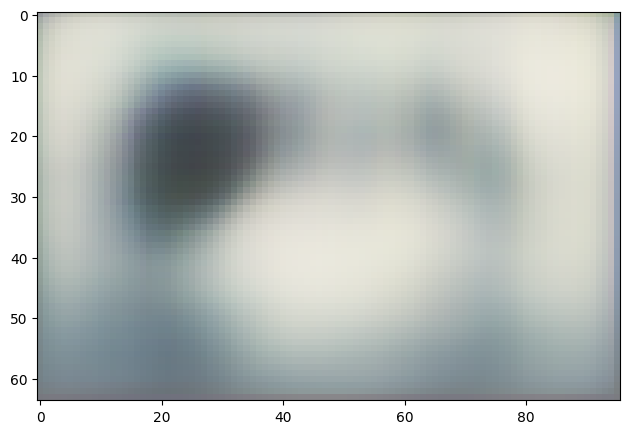

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 771ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 767ms/step
Epoch 5, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.03507617861032486
36/36 - 290s - 8s/step - loss: 0.0351 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


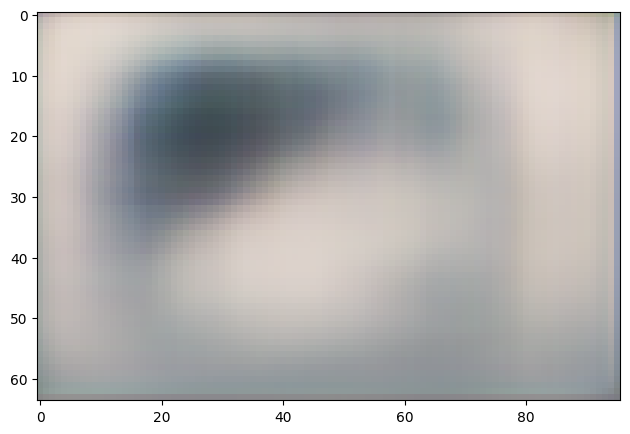

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 396ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 768ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 766ms/step
Epoch 6, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.032051585614681244
36/36 - 322s - 9s/step - loss: 0.0321 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


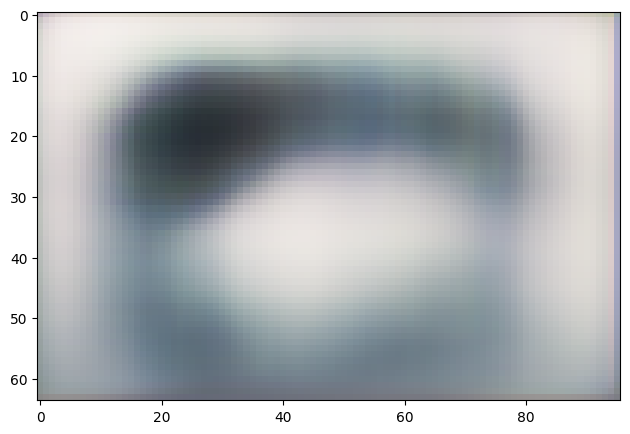

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 394ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 773ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 419ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 766ms/step
Epoch 7, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.030527736991643906
36/36 - 323s - 9s/step - loss: 0.0305 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


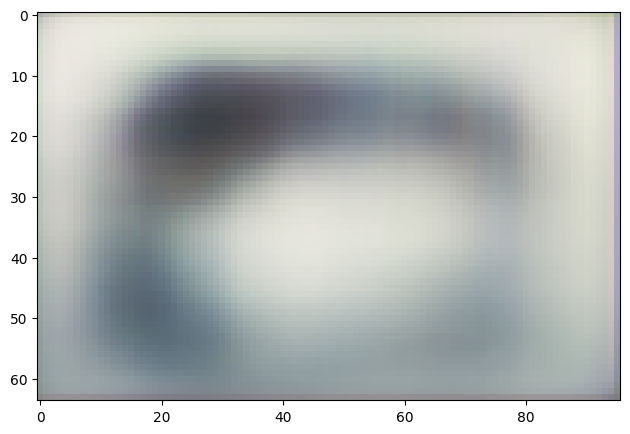

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 391ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 770ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 779ms/step
Epoch 8, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.027780115604400635
36/36 - 316s - 9s/step - loss: 0.0278 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


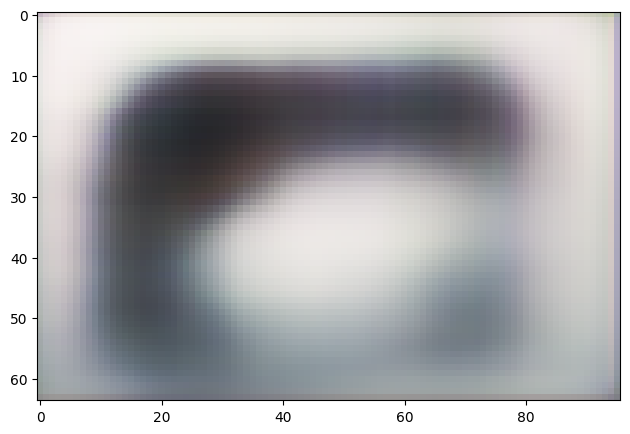

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 791ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 414ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 787ms/step
Epoch 9, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.027075883001089096
36/36 - 324s - 9s/step - loss: 0.0271 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


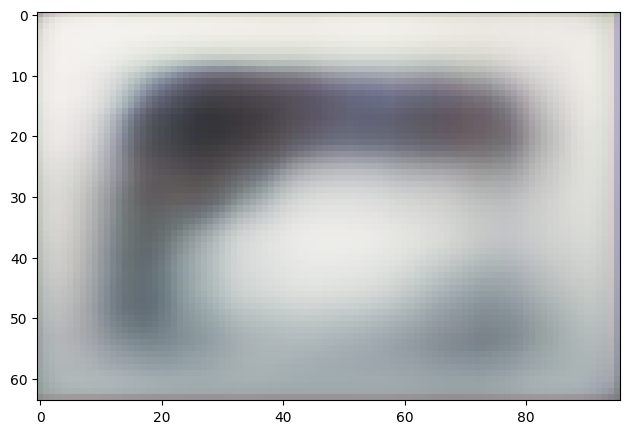

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 397ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 788ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 410ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 782ms/step
Epoch 10, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.026275303214788437
36/36 - 299s - 8s/step - loss: 0.0263 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


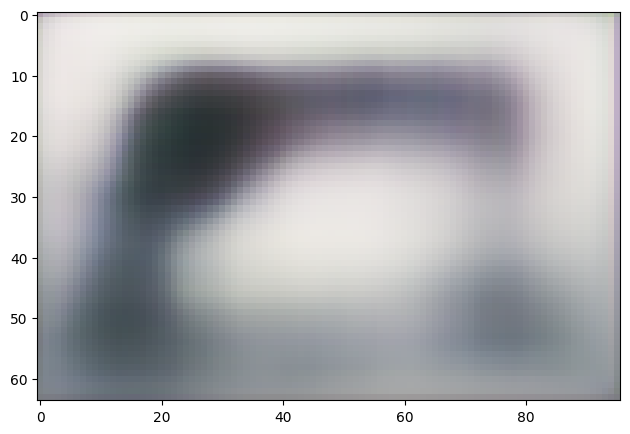

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 777ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 783ms/step
Epoch 11, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.027301274240016937
36/36 - 311s - 9s/step - loss: 0.0273 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


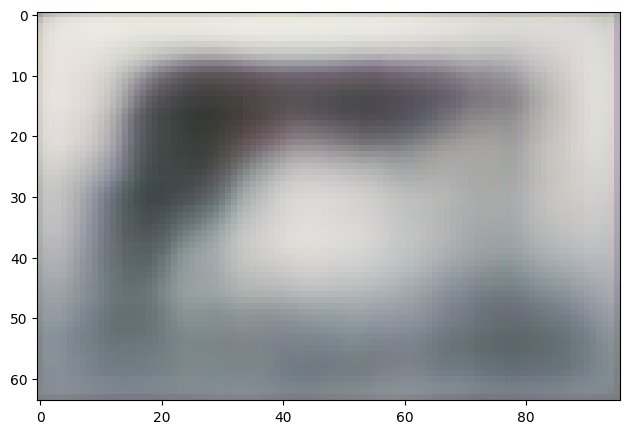

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 788ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 429ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 797ms/step
Epoch 12, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.025495944544672966
36/36 - 308s - 9s/step - loss: 0.0255 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


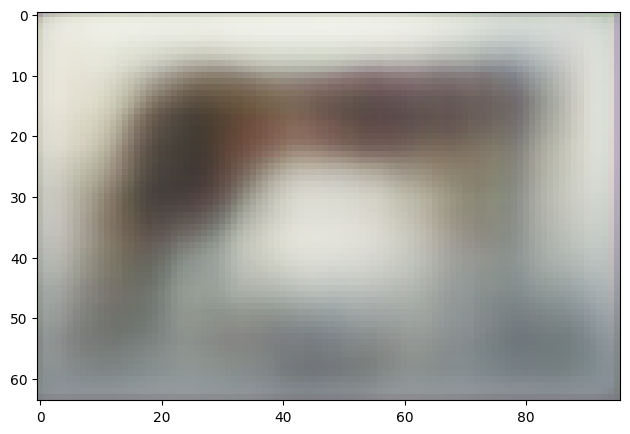

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 778ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 395ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 778ms/step
Epoch 13, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.02439928613603115
36/36 - 289s - 8s/step - loss: 0.0244 - val_loss: 0.0245 - learning_rate: 0.0010
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


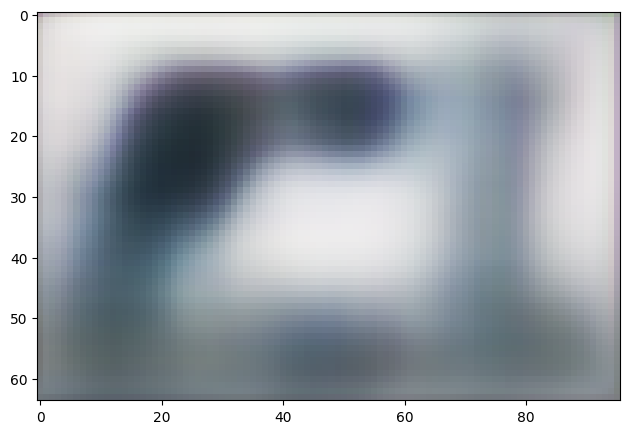

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 789ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 399ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 780ms/step
Epoch 14, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.023315249010920525
36/36 - 319s - 9s/step - loss: 0.0233 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


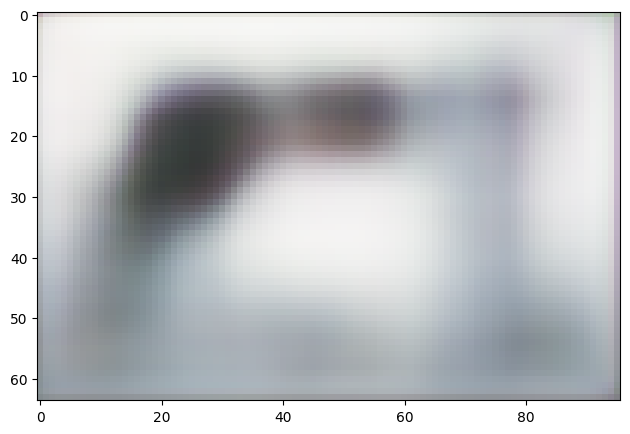

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 391ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 768ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 412ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 776ms/step
Epoch 15, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.02233385294675827
36/36 - 297s - 8s/step - loss: 0.0223 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


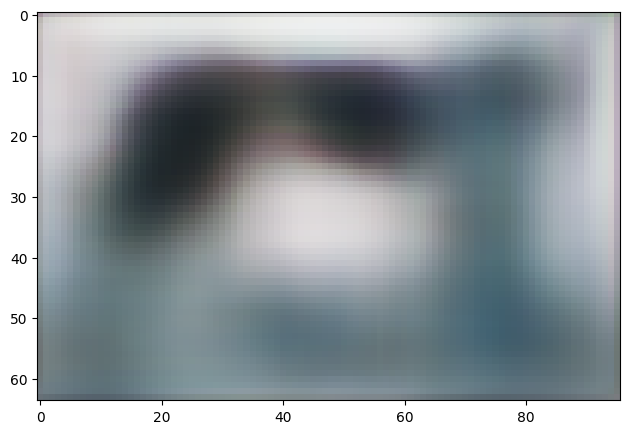

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 395ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 783ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 403ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 775ms/step
Epoch 16, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.021242743358016014
36/36 - 320s - 9s/step - loss: 0.0212 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


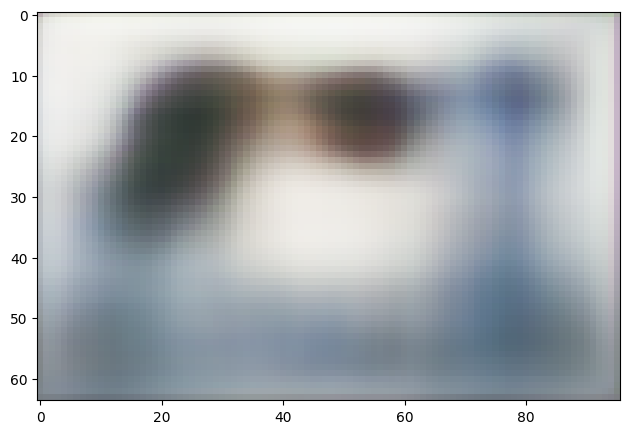

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 760ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 414ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 772ms/step
Epoch 17, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.021983707323670387
36/36 - 318s - 9s/step - loss: 0.0220 - val_loss: 0.0230 - learning_rate: 0.0010
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


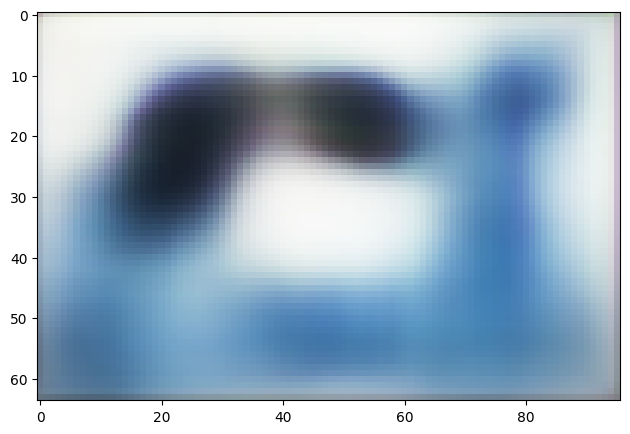

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 393ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 777ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 407ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 764ms/step
Epoch 18, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.01979486085474491
36/36 - 281s - 8s/step - loss: 0.0198 - val_loss: 0.0214 - learning_rate: 0.0010
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


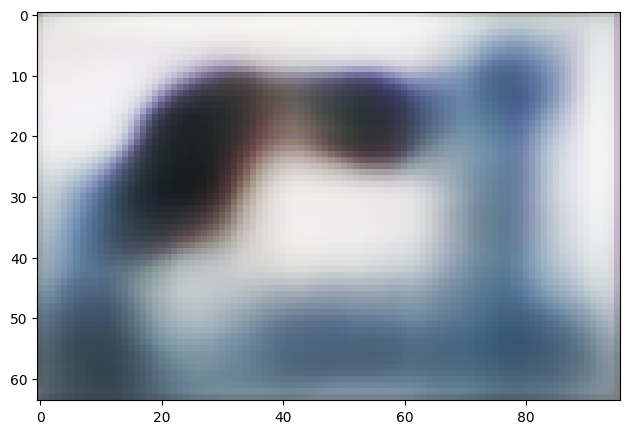

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 393ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 761ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 403ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 766ms/step
Epoch 19, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.02167004905641079
36/36 - 332s - 9s/step - loss: 0.0217 - val_loss: 0.0222 - learning_rate: 0.0010
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


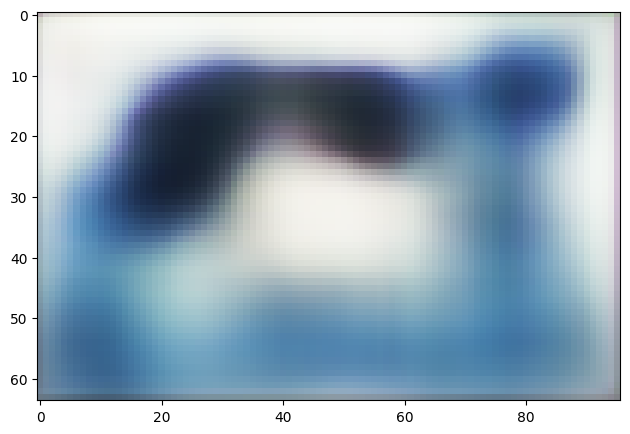

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 780ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 427ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 796ms/step
Epoch 20, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.019417783245444298
36/36 - 280s - 8s/step - loss: 0.0194 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


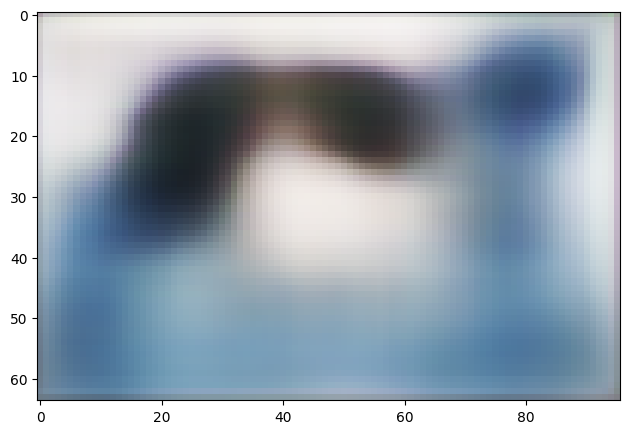

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 396ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 776ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 400ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 782ms/step
Epoch 21, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.019428526982665062
36/36 - 284s - 8s/step - loss: 0.0194 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


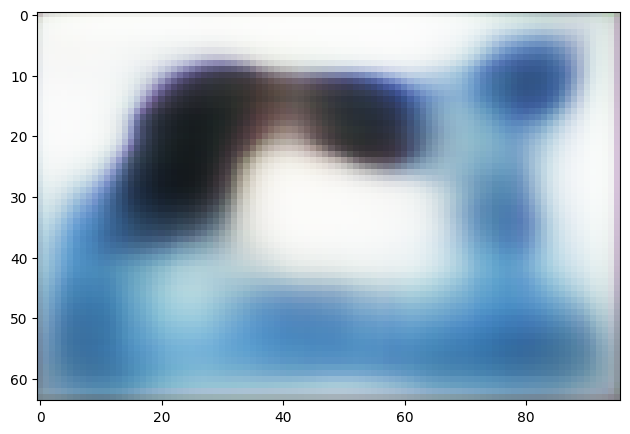

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 401ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 772ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 394ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 766ms/step
Epoch 22, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.018850509077310562
36/36 - 289s - 8s/step - loss: 0.0189 - val_loss: 0.0205 - learning_rate: 0.0010
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


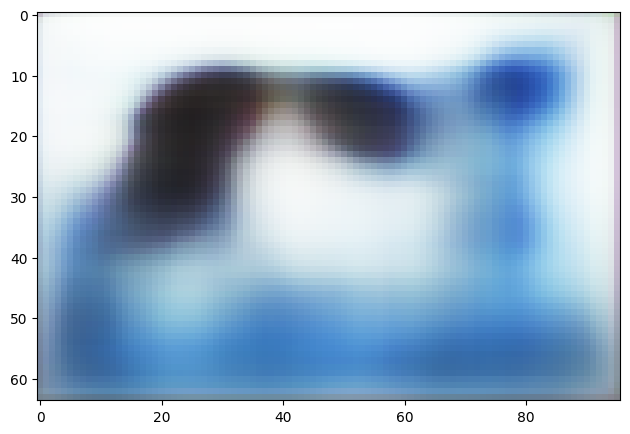

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 774ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 395ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 757ms/step
Epoch 23, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.01903974823653698
36/36 - 304s - 8s/step - loss: 0.0190 - val_loss: 0.0204 - learning_rate: 0.0010
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


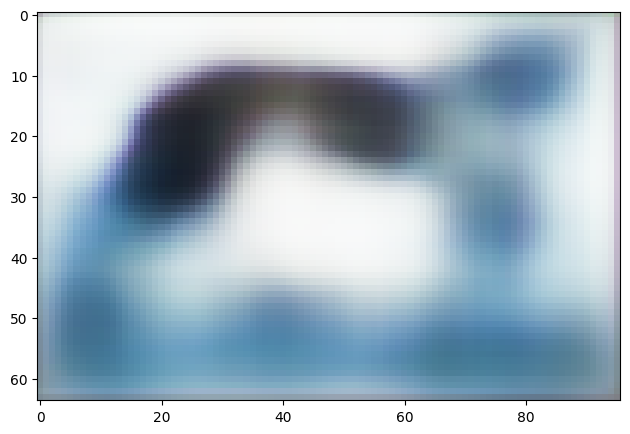

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 400ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 793ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 415ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 785ms/step
Epoch 24, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.01940246671438217
36/36 - 302s - 8s/step - loss: 0.0194 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


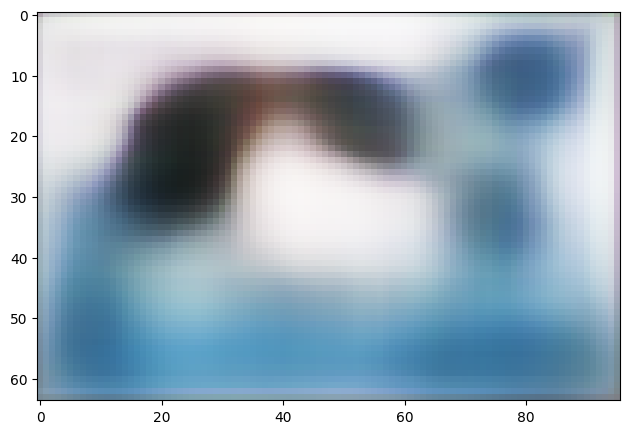

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 415ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 784ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 399ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 787ms/step
Epoch 25, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.017916183918714523
36/36 - 308s - 9s/step - loss: 0.0179 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


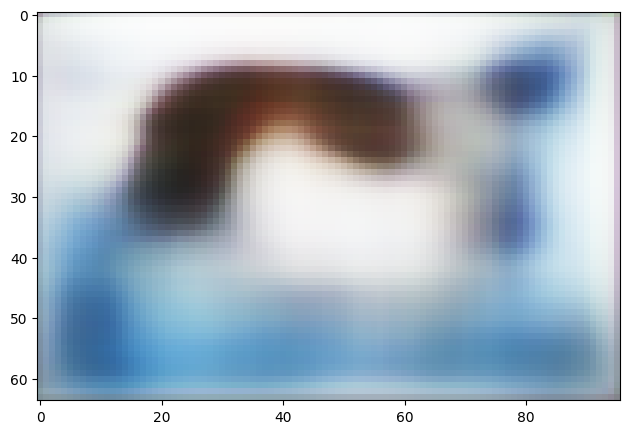

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 416ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 793ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 784ms/step
Epoch 26, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.01831177808344364
36/36 - 324s - 9s/step - loss: 0.0183 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


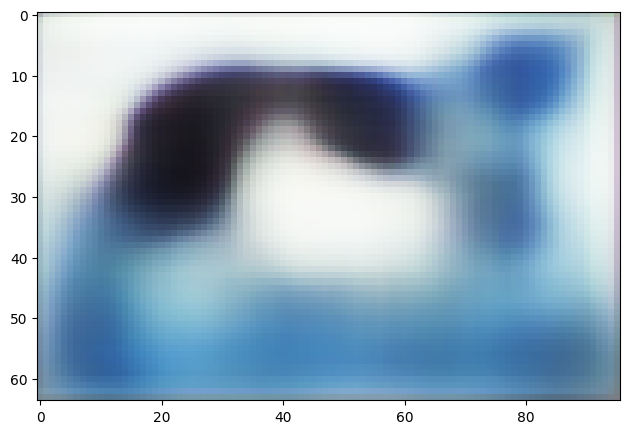

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 763ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 414ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 775ms/step
Epoch 27, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.01766034960746765
36/36 - 308s - 9s/step - loss: 0.0177 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 28/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


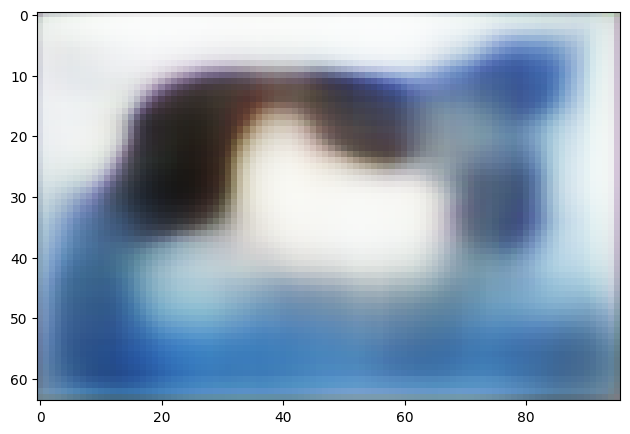

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 778ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 400ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 762ms/step
Epoch 28, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.01705879718065262
36/36 - 298s - 8s/step - loss: 0.0171 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


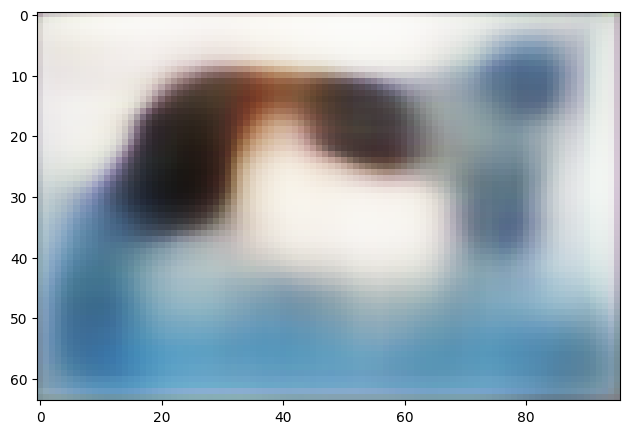

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 413ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 772ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 402ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 769ms/step
Epoch 29, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.017196478322148323
36/36 - 291s - 8s/step - loss: 0.0172 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


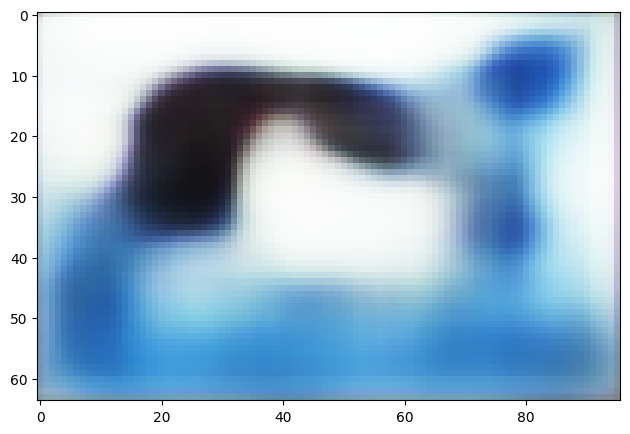

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 411ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 783ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 399ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 774ms/step
Epoch 30, Train aux_loss=0.03623046725988388, Val aux_loss=0.03623046725988388, Train MSE=0.07246093451976776, Val MSE=0.07246093451976776, Train Bitrate=0.0, Val Bitrate=0.0, Loss=0.01681847684085369
36/36 - 317s - 9s/step - loss: 0.0168 - val_loss: 0.0193 - learning_rate: 0.0010


In [83]:
aux_callback = AuxLossCallback(encoder, decoder, X_train, X_train)
model.fit(X_train, X_train,
          epochs=30, 
          batch_size=32,
          verbose=2,
          #validation_data=[X_test, X_test],
          validation_split=0.05,
        callbacks=[learning_rate_reduction, imgsample, aux_callback])

In [84]:
# Prepare evaluation dataset
cv_img_eval = []
for img in glob.glob("/kaggle/input/kodak-data/kodak_data/*.png"):
    n= cv2.imread(img)
    cv_img_eval.append(n)
print(len(cv_img_eval))

img_eval = np.zeros((len(cv_img_eval), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')
img_eval.shape

24


(24, 64, 96, 3)

In [111]:
init = 0
for i in cv_img_eval:
    img = i.astype('float32') / 255.
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    img_eval[init] = img
    init = init + 1

decoded_imgs = model.predict(img_eval)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step


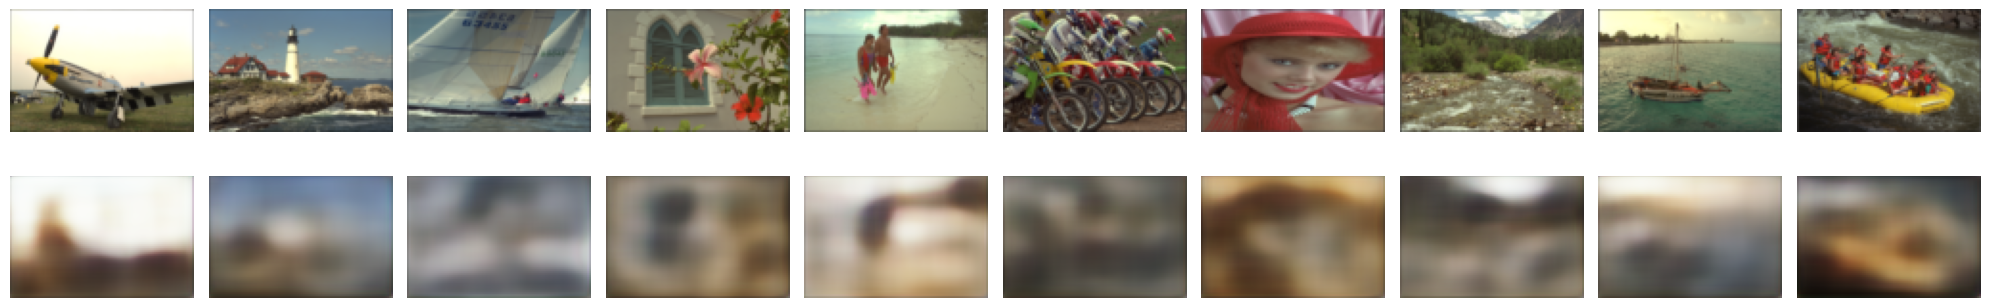

(24, 64, 96, 3)
(24, 64, 96, 3)


In [112]:
plt.figure(figsize=(20, 4))
for i in range(10):
    #img_rgb = cv2.cvtColor(cv_img[0], cv2.COLOR_BGR2RGB)
    plt.subplot(2, 10, i + 1)
    plt.imshow(img_eval[i][:,:,::-1])#.reshape(IMG_HEIGHT, IMG_WIDTH, 3))  
    plt.axis('off')

    plt.subplot(2, 10, i + 11)  
    plt.imshow(decoded_imgs[i][:,:,::-1])#.reshape(IMG_HEIGHT, IMG_WIDTH, 3))  
    plt.axis('off')
plt.tight_layout()
plt.show()
print(img_eval.shape)
print(decoded_imgs.shape)

In [130]:
from skimage.metrics import peak_signal_noise_ratio as psnr
import math

def calculate_psnr(original_imgs, decoded_imgs):
    """
    mse = np.mean((original_imgs - decoded_imgs) ** 2)
    if mse == 0:
        return float('inf') 
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr
    """
    #return -10 * math.log10(psnr(original_imgs, decoded_imgs, data_range=decoded_imgs.max() - decoded_imgs.min()))
    return psnr(original_imgs, decoded_imgs, data_range=decoded_imgs.max() - decoded_imgs.min())

def calculate_msssim(original_imgs, decoded_imgs):
    original_imgs_tf = tf.convert_to_tensor(original_imgs.astype('float32'))
    decoded_imgs_tf = tf.convert_to_tensor(decoded_imgs.astype('float32'))
    return -10 * math.log10(1-tf.image.ssim(original_imgs_tf, decoded_imgs_tf, max_val=1.0).numpy().mean())
    #return tf.image.ssim(original_imgs_tf, decoded_imgs_tf, max_val=1.0).numpy().mean()

def calculate_bitrate(img_eval, decoded_img, IMG_HEIGHT, IMG_WIDTH, num_images):
    """
    compressed_size_bits = compressed_size * 8 
    total_pixels = IMG_HEIGHT * IMG_WIDTH * num_images
    return compressed_size_bits / total_pixels
    """
    epsilon = 1e-10
    total_pixels = IMG_HEIGHT * IMG_WIDTH * num_images
    bpp = sum((np.log(np.mean((img - decoded_img) ** 2) + epsilon) 
               for img, decoded_img in zip(img_eval, decoded_imgs))) / (-np.log2(total_pixels)*10)
    
    return bpp

bits_per_pixel = 24
total_pixels = np.prod(decoded_imgs.shape[1:]) * decoded_imgs.shape[0]
total_bits = total_pixels * bits_per_pixel
compressed_size_bytes = total_bits / 8
num_images = decoded_imgs.shape[0]

psnr_value = calculate_psnr(img_eval, decoded_imgs)
#print(f'Original max: {img_eval.max()}, min: {img_eval.min()}')
#print(f'Decoded max: {decoded_imgs.max()}, min: {decoded_imgs.min()}')
msssim_value = calculate_msssim(img_eval, decoded_imgs)
bitrate_value = calculate_bitrate(img_eval, decoded_imgs, IMG_HEIGHT, IMG_WIDTH, num_images)

print(f'Evaluation Results:\n'
      f'- PSNR: {psnr_value:.2f} dB\n'
      f'- MS-SSIM: {msssim_value:.4f}\n'
      f'- Bitrate: {bitrate_value:.2f} bits/pixel')

Evaluation Results:
- PSNR: 18.61 dB
- MS-SSIM: 2.3090
- Bitrate: 0.62 bits/pixel


In [93]:
print(tf.__version__)

2.15.0
